In [3]:
import numpy as np
np.random.seed(1)
N=1000
def generate_experiment_data(size=N):
    d1 = np.random.normal(loc = 0.0, scale = 1.0, size = N) + np.random.randn(N) * 0.1
    d2 = np.random.normal(loc = 2.0, scale = 1.0, size = N) + np.random.randn(N) * 0.1
    return d1,d2
Wafer1, Wafer2 = generate_experiment_data(size=N)
print(np.shape(Wafer1))

(1000,)


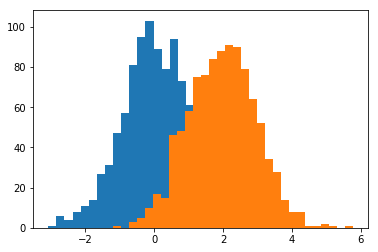

In [5]:
import matplotlib.pyplot as plt
plt.hist(Wafer1,bins=30)
plt.hist(Wafer2, bins=30)
plt.show()

In [6]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

def get_param():
    param = {
        'seed': 0,
        'eta': 0.1,
        'colsample_bytree': 0.5,
        'silent': 1,
        'objective': 'reg:linear',
        'max_depth': 5,
        'min_child_weight': 3,
        'nthread': 4,
        'eval_metric': 'rmse'
    }
    
    return param

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

def xgboost_algorithm(X, y, param=None, num_boost_round=100, maglify=1.0):
    y = np.multiply(y, maglify)
    real_param = param
    if param is None:
        real_param = get_param()
    data = pd.DataFrame(np.column_stack([X]),columns=['x'])
    label = pd.DataFrame(np.column_stack([y]))
    print(data.head())
    print(label.head())
    dtrain = xgb.DMatrix(data, label=label)
    print(real_param)
    mode = xgb.train(real_param, dtrain=dtrain, num_boost_round=num_boost_round, feval=xg_eval_mae, maximize=False)
    dtest = xgb.DMatrix(data)
    print(2)
    predicted = mode.predict(dtest)
    predicted = np.divide(predicted, maglify)
    return mode, predicted

(1000,) <class 'numpy.ndarray'> (1000,) <class 'numpy.ndarray'>
          x
0 -1.179379
1 -0.623449
2 -0.613936
3 -0.576855
4 -0.434991
          0
0 -3.069788
1 -2.825254
2 -2.790464
3 -2.768219
4 -2.755595
{'seed': 0, 'eta': 0.1, 'colsample_bytree': 0.5, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 5, 'min_child_weight': 3, 'nthread': 4, 'eval_metric': 'rmse'}
2


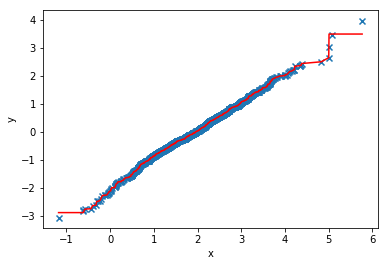

(array([ 5.,  2.,  3.,  5.,  6.,  8.,  9., 12., 18., 21., 19., 39., 35.,
        52., 51., 52., 67., 81., 59., 49., 65., 66., 50., 55., 41., 24.,
        28., 21., 15., 12., 13.,  6.,  4.,  3.,  1.,  0.,  0.,  0.,  0.,
         3.]),
 array([-2.8932495 , -2.733439  , -2.5736284 , -2.413818  , -2.2540076 ,
        -2.094197  , -1.9343865 , -1.774576  , -1.6147654 , -1.454955  ,
        -1.2951444 , -1.1353339 , -0.9755234 , -0.8157129 , -0.6559024 ,
        -0.4960919 , -0.3362814 , -0.17647089, -0.01666038,  0.14315012,
         0.30296063,  0.46277115,  0.62258166,  0.78239214,  0.9422027 ,
         1.1020131 ,  1.2618237 ,  1.4216342 ,  1.5814447 ,  1.7412552 ,
         1.9010657 ,  2.0608761 ,  2.2206867 ,  2.3804972 ,  2.5403078 ,
         2.7001183 ,  2.8599288 ,  3.0197392 ,  3.1795497 ,  3.3393602 ,
         3.4991708 ], dtype=float32),
 <a list of 40 Patch objects>)

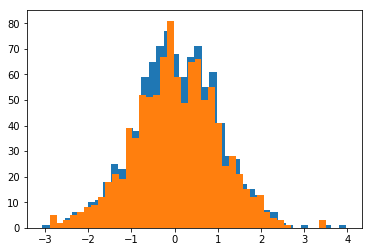

In [7]:
def plot_data(X, y, predicted):
    plt.scatter(X, y, marker='x')
    plt.plot(X, predicted, c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
X = np.sort(Wafer2)
y = np.sort(Wafer1)
print(np.shape(X), type(X), np.shape(y), type(y))
mode, predicted = xgboost_algorithm(X, y)
plot_data(X, y, predicted)
plt.hist(y,bins=40)
plt.hist(predicted,bins=40)

In [8]:
def compare_equal(data1, data2, precision=0.01):
    delta = abs(data1)*precision
    if data2 > data1 - delta and data2 < data1 + delta:
        return True
    else:
        return False
    
def compute_accuracy(Data1, Data2, sort=True, precision=0.01):
    X1 = Data1
    X2 = Data2
    if sort:
        X1 = np.sort(Data1)
        X2 = np.sort(Data2)
    correct_prediction = 0
    TotalCount = len(X1)
    for i in range(0, TotalCount):
        if compare_equal(X1[i], X2[i], precision):
            correct_prediction +=1
    
    accuracy = correct_prediction/TotalCount
    return accuracy

In [9]:
accuracy = compute_accuracy(predicted, y, sort=True, precision=0.01)
print(accuracy)

0.867


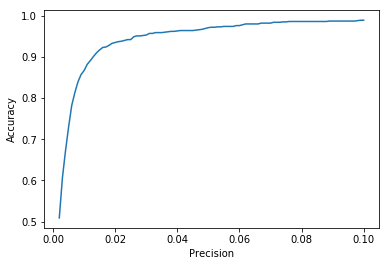

0.989


In [10]:
precisions = np.arange(0.1, 0.001, -0.001)
accuracies = [compute_accuracy(predicted, y, sort=True, precision=i) for i in precisions]
import matplotlib.pyplot as plt
plt.plot(precisions, accuracies)
plt.xlabel('Precision')
plt.ylabel('Accuracy')
plt.show()
print(np.max(accuracies))

In [11]:
def compute_accuracy_with_size(size_list, precision=0.01):
    accuracies = []
    for i in size_list:
        Wafer1, Wafer2 = generate_experiment_data(i)
        X = np.sort(Wafer2)
        y = np.sort(Wafer1)
        print(np.shape(X), type(X), np.shape(y), type(y))
        mode, predicted = xgboost_algorithm(X, y)
#         print(np.shape(Wafer1), np.shape(wafer))
        accuracy = compute_accuracy(y, predicted, sort=True, precision=precision)
#         print("Hehe", accuracy)
        accuracies.append(accuracy)
        
    return accuracies
        
size_list = [i for i in range(100, 10000, 1000)]
# size_list = [100,10000]
accuracies = compute_accuracy_with_size(size_list, 0.05)

(1000,) <class 'numpy.ndarray'> (1000,) <class 'numpy.ndarray'>
          x
0 -0.999014
1 -0.859162
2 -0.759062
3 -0.689734
4 -0.667248
          0
0 -3.177404
1 -2.929788
2 -2.820242
3 -2.655683
4 -2.646224
{'seed': 0, 'eta': 0.1, 'colsample_bytree': 0.5, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 5, 'min_child_weight': 3, 'nthread': 4, 'eval_metric': 'rmse'}
2
(1000,) <class 'numpy.ndarray'> (1000,) <class 'numpy.ndarray'>
          x
0 -1.386857
1 -1.250787
2 -0.741395
3 -0.740233
4 -0.671646
          0
0 -3.122435
1 -2.833868
2 -2.690956
3 -2.639927
4 -2.396069
{'seed': 0, 'eta': 0.1, 'colsample_bytree': 0.5, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 5, 'min_child_weight': 3, 'nthread': 4, 'eval_metric': 'rmse'}
2
(1000,) <class 'numpy.ndarray'> (1000,) <class 'numpy.ndarray'>
          x
0 -1.271917
1 -1.051372
2 -0.875147
3 -0.649278
4 -0.512006
          0
0 -3.307825
1 -3.282543
2 -2.937965
3 -2.853842
4 -2.424908
{'seed': 0, 'eta': 0.1, 'colsample_bytree'

[100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100] 0.98


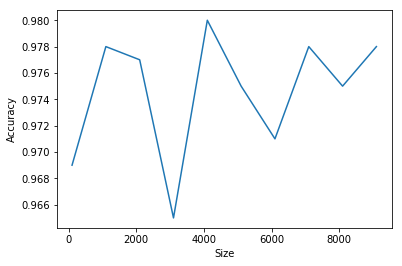

0.9746


In [12]:
print(size_list, np.max(accuracies))
plt.plot(size_list, accuracies)
plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.show()
print(np.average(accuracies))